In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [202]:
# we want to focus TN cancer dataset
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')
cancer_costs_df = cancer_costs_df.loc[cancer_costs_df['state'] == 'TENNESSEE']
cancer_costs_df = cancer_costs_df.rename(columns = {'analysis_value': 'cancer_avg_cost'})
cancer_costs_df = cancer_costs_df[['state', 'county', 'urban', 'cancer_avg_cost']]
cancer_costs_df.shape

(95, 4)

In [203]:
# income dataset
income_df = pd.read_csv('../data/irs_county_2016.csv')
income_df = income_df.loc[income_df['STATE'] == 'TN']
income_df = income_df[['STATE','agi_stub', 'COUNTYNAME', 'N02650', 'A02650']]
income_df.columns = ['state', 'income_bucket','county', 'returns_with_total_inc','total_inc_amt']
income_df.head(2)

,state,income_bucket,county,returns_with_total_inc,total_inc_amt
19752,TN,1,Tennessee,29090,-2710342
19753,TN,2,Tennessee,439780,2441687


In [205]:
# aggregation of income data
income_agg = income_df.groupby(['state','county']).agg('sum').reset_index()
income_agg['avg_income'] = round(income_agg.total_inc_amt * 1000 / income_agg.returns_with_total_inc, 0)
income_agg = income_agg[['county', 'avg_income']]
income_agg.shape

(96, 2)

In [206]:
cancer_costs_df = pd.merge(cancer_costs_df, income_agg, on = ['county'], how = 'inner')

In [209]:
cancer_costs_df['cancer_cost_ratio'] = cancer_costs_df['cancer_avg_cost'] / cancer_costs_df['avg_income']
cancer_costs_df.shape

(95, 6)

In [208]:
# import hospital dataset
TN_hospitals = pd.read_csv('../data/TN_hospitals_conty.csv')

In [190]:
TN_hospitals_counts = TN_hospitals.County.value_counts()
TN_hospitals_counts = TN_hospitals_counts.to_frame().reset_index()

In [211]:
TN_hospitals_counts = TN_hospitals_counts.rename(columns = {'index': 'county', 'County': 'numbers_hospitals'})
TN_hospitals_counts.shape

(71, 2)

In [212]:
# merge cander data and hospital numbers
cancer_costs_df= pd.merge(cancer_costs_df, TN_hospitals_counts, on = ['county'], how = 'left')
cancer_costs_df.shape

(95, 8)

In [216]:
# import census dataset and merge with cancer df
tn_census = pd.read_csv('../data/tn_census_mod.csv')
tn_census = tn_census.rename(columns = {'County': 'county'})

In [217]:
cancer_costs_df= pd.merge(cancer_costs_df, tn_census, on = ['county'], how = 'left')

In [218]:
cancer_costs_df.head(2)

,state,county,urban,cancer_avg_cost,avg_income,cancer_cost_ratio,numbers_hospitals_x,numbers_hospitals_y,Population_V2019,"Persons under 5 years, percent","Persons under 18 years, percent","Persons 65 years and over, percent","Female persons, percent","Persons without health insurance, under age 65 years, percent","Persons in poverty, percent","Total nonemployer establishments, 2018"
0,TENNESSEE,Anderson County,Urban,15454,53617.0,0.288229,2.0,2.0,76978,5.40%,21.20%,20.30%,51.30%,11.60%,16.50%,4810
1,TENNESSEE,Bedford County,Rural,19219,47308.0,0.406253,NaN,NaN,49713,6.70%,25.40%,15.20%,50.70%,14.70%,14.40%,3137


In [48]:
avg_cancer_ratio = cancer_costs_df.cancer_cost_ratio.mean()
avg_cancer_ratio

0.4149767494462439

In [49]:
cancer_costs_df['above_avg_cancer_ratio'] = cancer_costs_df['cancer_cost_ratio'] > avg_cancer_ratio

In [50]:
cancer_costs_df.head()

,state,county,urban,cancer_avg_cost,avg_income_x,cancer_cost_ratio,avg_income_y,above_avg_cancer_ratio
0,AL,Autauga County,Urban,19293,55843.0,0.345486,55843.0,False
1,AL,Baldwin County,Rural,17151,62832.0,0.272966,62832.0,False
2,AL,Barbour County,Rural,19469,40269.0,0.483474,40269.0,True
3,AL,Bibb County,Urban,17234,47380.0,0.363740,47380.0,False
4,AL,Blount County,Urban,20317,49535.0,0.410154,49535.0,False


In [48]:
X = cancer_costs_df[['urban_Urban', 'avg_income','cancer_avg_cost']]
y = cancer_costs_df.above_avg_cancer_ratio

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#import graphviz
from IPython.display import SVG

In [51]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier()

In [52]:
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

1.0


In [53]:
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9856584093872229


In [54]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 5)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=1000)

In [55]:
y_pred_train = forest.predict(X_train)
print(metrics.accuracy_score(y_train, y_pred_train))

0.9934754240974336


In [56]:
y_pred = forest.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9830508474576272


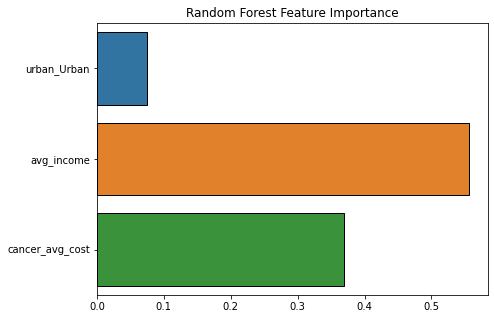

In [57]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = forest.feature_importances_, y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Random Forest Feature Importance');

In [58]:
# Logistic model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

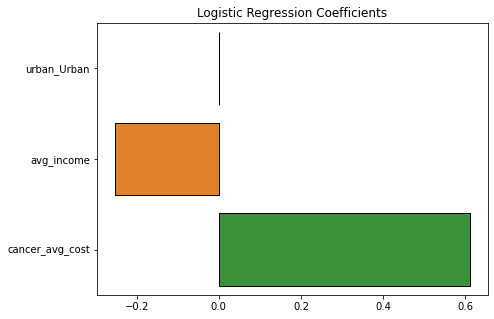

In [59]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients');

In [61]:
y_pred_prob = logistic_model.predict_proba(X_test)[:,1]

print(metrics.roc_auc_score(y_test, y_pred_prob))

1.0


In [69]:
X = cancer_costs_df[['urban_Urban',]]
y = cancer_costs_df.above_avg_cancer_ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

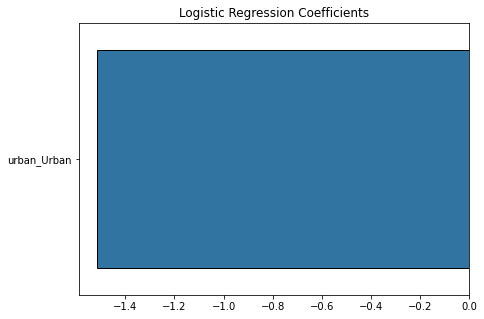

In [70]:
fig, ax = plt.subplots(figsize = (7,5))
sns.barplot(x = logistic_model.coef_[0], y = list(X.columns), ax = ax, edgecolor = 'black')
plt.title('Logistic Regression Coefficients');

In [71]:
geographic_info = pd.read_csv('../data/geographic_profile.csv')

In [72]:
geographic_info.isna().sum()

state                                                                    0
county                                                                   0
Median Household Income (5y Average)                                     0
Median Household Income for +7-person Households (5y Avg.)             777
Median Household Income for 1-person Households (5y Avg.)                0
Median Household Income for 2-person Households (5y Avg.)                1
Median Household Income for 3-person Households (5y Avg.)               19
Median Household Income for 4-person Households (5y Avg.)               39
Median Household Income for 5-person Households (5y Avg.)              125
Median Household Income for 6-person Households (5y Avg.)              455
Percent Below Federal Poverty Level (1y Avg.)                         2389
Percent Below Federal Poverty Level (5y Avg.)                            0
Percent of +4 Person Households with +3 Workers (5y Avg.)                0
Percent of +4 Person Hous

In [73]:
geographic_info = geographic_info[['state', 'county', 'Percent Below Federal Poverty Level (5y Avg.)']]
geographic_info.head(2)

,state,county,Percent Below Federal Poverty Level (5y Avg.)
0,Alabama,Autauga County,0.122660
1,Alabama,Baldwin County,0.129938


In [77]:
%who

DecisionTreeClassifier	 LogisticRegression	 RandomForestClassifier	 SVG	 X	 X_test	 X_train	 avg_cancer_ratio	 ax	 
cancer_costs_df	 export_graphviz	 fig	 forest	 fp_rate	 geographic_info	 income_agg	 income_df	 logistic_model	 
metrics	 np	 pd	 plt	 sns	 state_abbrev	 thresholds	 titanic	 tp_rate	 
train_test_split	 warnings	 y	 y_pred	 y_pred_prob	 y_pred_train	 y_test	 y_train	 


In [80]:
cancer_costs_df.head()

,cancer_avg_cost,avg_income,above_avg_cancer_ratio,urban_Urban,cancer_cost_ratio_0.10095727836608998,cancer_cost_ratio_0.10231502980382007,cancer_cost_ratio_0.11366512020244622,cancer_cost_ratio_0.13391260162601626,cancer_cost_ratio_0.13427749640467704,cancer_cost_ratio_0.1347484470139615,...,county_Yell County,county_Yellowstone County,county_Yoakum County,county_Yolo County,county_York County,county_Young County,county_Yuba County,county_Yuma County,county_Zapata County,county_Zavala County
0,19293,55843.0,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17151,62832.0,False,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19469,40269.0,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17234,47380.0,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20317,49535.0,False,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1]:
cancer_costs_df = pd.read_csv('../data/mmd_cancer_data.csv')

NameError: name 'pd' is not defined